**#Finetuning of the Gpt model on the quora question-answer dataset**

In [ ]:
#Finetuning of the Gpt model on the quora question-answer dataset
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from datasets import load_dataset, Dataset
from transformers import GPT2Tokenizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stop words, stemmer, and lemmatizer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Load the dataset
dataset = load_dataset("toughdata/quora-question-answer-dataset")

# Preprocess text function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing to dataset
dataset = dataset.map(lambda x: {'question': preprocess_text(x['question']), 'answer': preprocess_text(x['answer'])})

# Check dataset structure
print(dataset['train'][0])


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/akshara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/akshara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


{'question': 'whenev get shower girlfriend want join?', 'answer': 'isn’t awful? would swear wasn’t enough hot water go around!'}


In [ ]:
# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the dataset
def tokenize_function(examples):
    inputs = [ex for ex in examples['question']]
    targets = [ex for ex in examples['answer']]
    model_inputs = tokenizer(inputs, padding="max_length", truncation=True, max_length=128)
    labels = tokenizer(targets, padding="max_length", truncation=True, max_length=128)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply the tokenization function
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["question", "answer"])

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 56402
    })
})

In [ ]:
# Split into training and test sets
train_test_split = tokenized_dataset['train'].train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Verify the structure of the datasets
print(train_dataset[0])
print(test_dataset[0])

{'input_ids': [13466, 530, 35940, 3194, 30, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256], 'attention_mask': [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

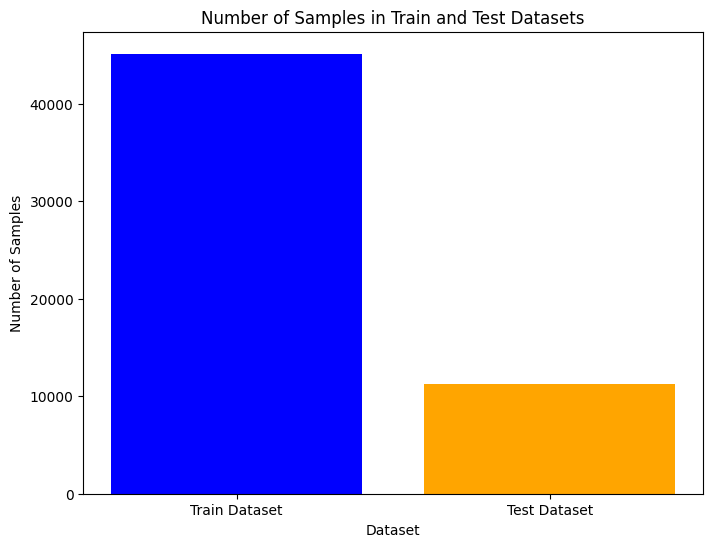

In [ ]:
#Comparison of the training and the test dataset
import matplotlib.pyplot as plt

# Assuming you have the datasets as shown
# train_dataset and test_dataset are lists or similar structures

# Calculate the sizes of the datasets
num_train_samples = len(train_dataset)
num_test_samples = len(test_dataset)

# Data for plotting
datasets = ['Train Dataset', 'Test Dataset']
sizes = [num_train_samples, num_test_samples]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(datasets, sizes, color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Train and Test Datasets')

# Save the plot to a file
plt.savefig('dataset_distribution.png')  # Save the plot as a PNG file

# Display the plot
plt.show()


In [ ]:
import os
import torch
from transformers import GPT2LMHeadModel, Trainer, TrainingArguments

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Initialize the GPT-2 model
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Define a custom Trainer class to override compute_loss method
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # Ensure labels are in the same device as model inputs
        labels = labels.to(model.device)
        outputs = model(**inputs)
        logits = outputs.logits
        # Shift the labels and logits for next token prediction
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        return (loss, outputs) if return_outputs else loss


In [ ]:
#Evaluating a Fine-Tuned GPT-2 Model on a Subset of Training Data
import os
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from datasets import load_metric

# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Find the tarzan directory in the current directory
current_directory = os.path.abspath(os.getcwd())
tarzan_directory = os.path.join(current_directory, "tarzan")

# Load the fine-tuned model from the tarzan directory
model = GPT2LMHeadModel.from_pretrained(tarzan_directory)

# Reinitialize the Trainer to avoid state issues
eval_training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=1,  # Set batch size to 1 to generate predictions one at a time
    logging_dir='./logs',
    no_cuda=True  # Ensure only CPU is used
)

# Define the CustomTrainer class
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        labels = labels.to(model.device)
        outputs = model(**inputs)
        logits = outputs.logits
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Extract a subset of the training dataset (e.g., first 100 rows)
train_dataset_subset = train_dataset.select(range(100))

eval_trainer = CustomTrainer(
    model=model,
    args=eval_training_args,
    eval_dataset=train_dataset_subset,
)

# Generate predictions
with torch.no_grad():
    predictions = eval_trainer.predict(train_dataset_subset)

# Decode predictions
preds = predictions.predictions.argmax(-1).tolist()  # Convert logits to predictions and then to list
labels = predictions.label_ids.tolist()  # Convert labels to list

# Decode predictions and references
preds = [tokenizer.decode(pred, skip_special_tokens=True) for pred in preds]
refs = [tokenizer.decode(label, skip_special_tokens=True) for label in labels]

# Print results
for i, question in enumerate(refs):
    print("Question:", question)
    print("Answer:", preds[i])
    print("-" * 50)


Question: thought..
Answer: ,
--------------------------------------------------
Question: don’t counter it, true statement. strongli suggest read two treatis government, especi second treatise, john locke, also social contract jean-jacqu rousseau. foundat thinker enlighten whose principl declar independ unit state constitut based, well fundament valu american justic civil rights. learn right abil someth without need ask permission, right end imping right anyon else, vice versa. right never involv demand time, labor, servic anoth person. engag slavery. purpos government, explain locke, protect human rights, govern must structur minim
Answer: ,�
--------------------------------------------------
Question: idea. use kindle, although three nooks. mayb batteri dead.
Answer: ,..
--------------------------------------------------
Question: granit marbl littl bit similar fall categori i.e. natur stone attributes. differ granit marble. 1. granit le durabl compar marble. 2. granit mostli resist

In [ ]:
#Evaluating a Fine-Tuned GPT-2 Model on a Subset of Test Data
import os
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
from datasets import load_metric

# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Find the tarzan directory in the current directory
current_directory = os.path.abspath(os.getcwd())
tarzan_directory = os.path.join(current_directory, "tarzan")

# Load the fine-tuned model from the tarzan directory
model = GPT2LMHeadModel.from_pretrained(tarzan_directory)

# Reinitialize the Trainer to avoid state issues
eval_training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=1,  # Set batch size to 1 for generating predictions
    logging_dir='./logs',
    no_cuda=True  # Ensure only CPU is used
)

# Define the CustomTrainer class
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        labels = labels.to(model.device)
        outputs = model(**inputs)
        logits = outputs.logits
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Assuming test_dataset is already defined and loaded
# Extract a subset of the test dataset (e.g., first 100 rows) and use raw questions
test_dataset_subset = test_dataset.select(range(100))

# Create a new trainer for generating predictions
eval_trainer = CustomTrainer(
    model=model,
    args=eval_training_args,
    eval_dataset=test_dataset_subset,
)

# Generate predictions
with torch.no_grad():
    predictions = eval_trainer.predict(test_dataset_subset)

# Decode predictions
preds = predictions.predictions.argmax(-1).tolist()  # Convert logits to predictions and then to list
labels = predictions.label_ids.tolist()  # Convert labels to list

# Decode predictions and references
preds = [tokenizer.decode(pred, skip_special_tokens=True) for pred in preds]
refs = [tokenizer.decode(label, skip_special_tokens=True) for label in labels]

# Print results
for i, question in enumerate(refs):
    print("Question:", question)
    print("Answer:", preds[i])
    print("-" * 50)


Question: wow! great answers. live near philadelphia, pa, think garden best world. longwood (a someon mention above)chanticleernemourswinterthur
Answer: ,, garden garden garden
--------------------------------------------------
Question: ye close!🥰🥰 rm namjoon’ twin respekful girl🥰, brother classmate😉 pretty, love much. 🥰 love style,and relationship namjoon. close 🥺🥺 namjoon, best leader 🥰 pictur twin hope answer help you……….😑😑😑😑 wtf? u okay? u act stupid right?🤔🤨😑 rm namjoon person, rm nicknam namjoon! 😑😑
Answer: ,�
--------------------------------------------------
Question: canada need see specialist must get referr primari care doctor take averag 12 week see one least. unit state take mere 20 day see specialist. massiv differ,ridicul difference. canada' health care great mani canadian come get healthcar buy pharmaceut?
Answer: ,�
--------------------------------------------------
Question: find appl id back: go offici site: [linked_text: appl idyour appl id account use appl service

/tmp/ipykernel_337487/4159861745.py:53: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu = load_metric('bleu')
/home/akshara/.local/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/akshara/.local/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect th

BLEU Score: {'bleu': 1.5401423320497265e-07, 'precisions': [0.13886178861788617, 0.03566265060240964, 0.030562347188264057, 0.031413612565445025], 'brevity_penalty': 3.2982655415367712e-06, 'length_ratio': 0.07341004583651642, 'translation_length': 3075, 'reference_length': 41888}
ROUGE Score: {'rouge1': AggregateScore(low=Score(precision=0.1434563886184095, recall=0.009852850400308644, fmeasure=0.0171966730795175), mid=Score(precision=0.16239783798147187, recall=0.011602693880607362, fmeasure=0.019995884713725664), high=Score(precision=0.18182714585273296, recall=0.013318837173384656, fmeasure=0.02279500152972633)), 'rouge2': AggregateScore(low=Score(precision=0.0035350595238095245, recall=0.00023693731334020692, fmeasure=0.0004250080673267109), mid=Score(precision=0.0067428571428571425, recall=0.00043733423077153344, fmeasure=0.000789443759009272), high=Score(precision=0.010593690476190474, recall=0.0006718183735867851, fmeasure=0.0012212021997453722)), 'rougeL': AggregateScore(low=S

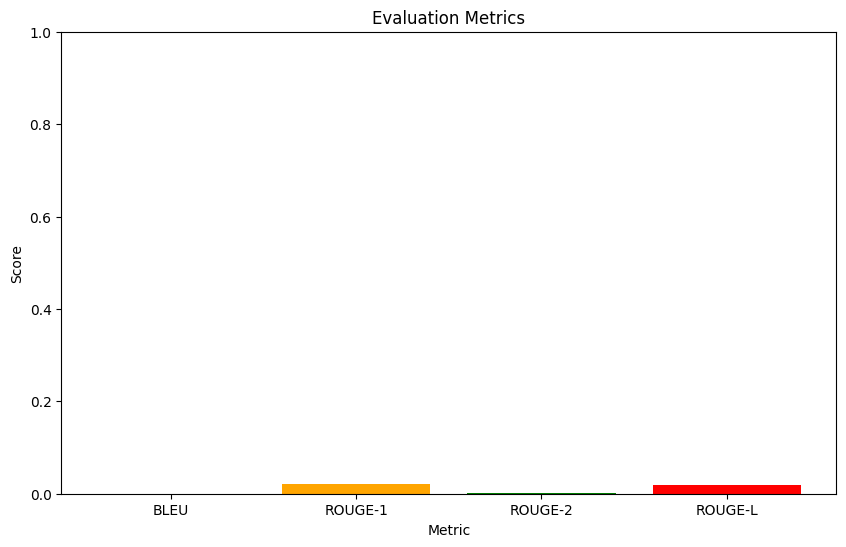

In [ ]:
#Calculation of the Metrics bleu score by taking the fine-tuned model and generating the infrence on 1000 rows of the test dataset
import os
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from datasets import load_metric

# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Find the tarzan directory in the current directory
current_directory = os.path.abspath(os.getcwd())
tarzan_directory = os.path.join(current_directory, "tarzan")

# Load the fine-tuned model from the tarzan directory
model = GPT2LMHeadModel.from_pretrained(tarzan_directory)

# Reinitialize the Trainer to avoid state issues
eval_training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=32,  # Set batch size to 1 to reduce memory usage
    logging_dir='./logs',
    no_cuda=True  # Ensure only CPU is used
)

# Define the CustomTrainer class
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        labels = labels.to(model.device)
        outputs = model(**inputs)
        logits = outputs.logits
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Assuming test_dataset is already defined and loaded
# Take only the first 100 rows of the test dataset
test_dataset_100 = test_dataset.select(range(1000))

eval_trainer = CustomTrainer(
    model=model,
    args=eval_training_args,
    eval_dataset=test_dataset_100,
)

# Generate predictions and compute evaluation metrics
with torch.no_grad():
    predictions = eval_trainer.predict(test_dataset_100)

# Load metrics
bleu = load_metric('bleu')
rouge = load_metric('rouge')

# Convert predictions and references to lists of strings
preds = predictions.predictions.argmax(-1).tolist()  # Convert logits to predictions and then to list
labels = predictions.label_ids.tolist()  # Convert labels to list

# Decode predictions and references
preds = [tokenizer.decode(pred, skip_special_tokens=True) for pred in preds]
refs = [tokenizer.decode(label, skip_special_tokens=True) for label in labels]

# BLEU score
bleu_score = bleu.compute(predictions=[pred.split() for pred in preds], references=[[ref.split()] for ref in refs])
print("BLEU Score:", bleu_score)

# ROUGE score
rouge_score = rouge.compute(predictions=preds, references=refs)
print("ROUGE Score:", rouge_score)

# Plotting metrics
metrics = {
    "BLEU": bleu_score["bleu"],
    "ROUGE-1": rouge_score["rouge1"].mid.fmeasure,
    "ROUGE-2": rouge_score["rouge2"].mid.fmeasure,
    "ROUGE-L": rouge_score["rougeL"].mid.fmeasure
}

# Plot metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)
plt.savefig('evaluation_metrics.png')
plt.show()


In [ ]:
#Finetuning of the training data using the Gpt-2
import os

# Step 4: Setting Up Training Arguments and Training

# Get the current directory
current_directory = os.path.abspath(os.getcwd())

# Create a folder named "tarzan" in the current directory
tarzan_directory = os.path.join(current_directory, "tarzan")
os.makedirs(tarzan_directory, exist_ok=True)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Initialize the Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()

# Save the trained model in the "tarzan" folder
trainer.save_model(tarzan_directory)

/home/akshara/.local/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,4.745700,4.585258
2,4.213000,4.566879
3,4.853800,4.534225


In [ ]:
print(train_dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 45121
})


In [ ]:
print(test_dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 11281
})


**Evaluating T5 Model on Quora Question-Answer Dataset Using BLEU Score for Generated Answers**

[nltk_data] Downloading package punkt to /home/akshara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/akshara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/akshara/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!

Calculating BLEU scores:  76%|██████████████████████████████████████████████████████████████████▉                     | 38/50 [00:00<00:00, 61.38it/s]/home/akshara/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Calculating BLEU scores: 100%|████████████████████████████████████

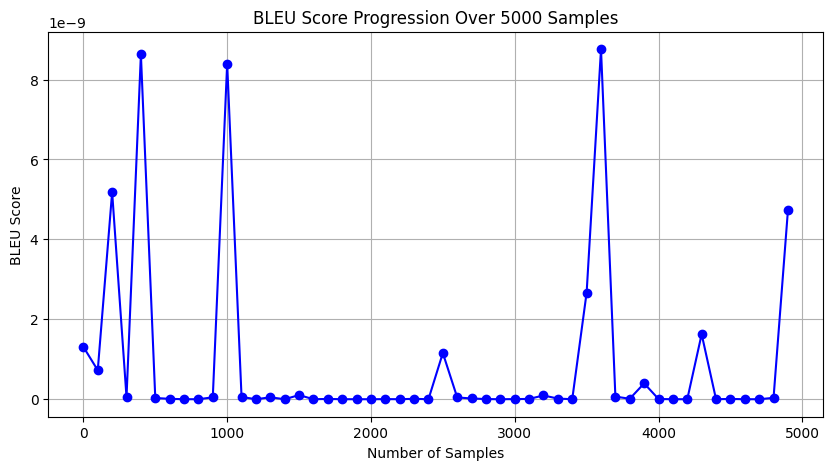

Final BLEU Score: 0.0000


In [ ]:
#Evaluating T5 Model on Quora Question-Answer Dataset Using BLEU Score for Generated Answers
from datasets import load_dataset
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
import matplotlib.pyplot as plt

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Load the dataset
dataset = load_dataset("toughdata/quora-question-answer-dataset")

# Initialize the T5 model and tokenizer for question answering
model_name = "google-t5/t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
qa_pipeline = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# Preprocessing functions
def get_wordnet_pos(treebank_tag):
    """Convert treebank tags to wordnet tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def preprocess(text, use_stemming=True):
    tokens = word_tokenize(text.lower())
    if use_stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens if token.isalpha()]
    else:
        lemmatizer = WordNetLemmatizer()
        pos_tags = nltk.pos_tag(tokens)
        tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos) or wordnet.NOUN) for token, pos in pos_tags if token.isalpha()]
    return ' '.join(tokens)

# Select first 5000 rows
subset_size = 5000
questions = dataset['train']['question'][:subset_size]
answers = dataset['train']['answer'][:subset_size]

# Preprocess questions and answers
processed_questions = [preprocess(q) for q in questions]
processed_answers = [preprocess(a) for a in answers]

# Generate answers using the T5 model
generated_answers = []
for question in tqdm(processed_questions, desc="Generating answers"):
    result = qa_pipeline(question)
    generated_answers.append(result[0]['generated_text'])

# Preprocess generated answers
processed_generated_answers = [preprocess(ans, use_stemming=True) for ans in generated_answers]

# Calculate BLEU scores and plot the progress
def compute_bleu(reference_texts, hypothesis_texts):
    references = [[ref.split()] for ref in reference_texts]
    hypotheses = [hyp.split() for hyp in hypothesis_texts]
    return corpus_bleu(references, hypotheses)

bleu_scores = []
batch_size = 100
for i in tqdm(range(0, len(processed_answers), batch_size), desc="Calculating BLEU scores"):
    batch_references = processed_answers[i:i+batch_size]
    batch_hypotheses = processed_generated_answers[i:i+batch_size]
    bleu_score = compute_bleu(batch_references, batch_hypotheses)
    bleu_scores.append(bleu_score)

# Plot BLEU scores
plt.figure(figsize=(10, 5))
plt.plot(range(0, subset_size, batch_size), bleu_scores, marker='o', linestyle='-', color='b')
plt.title('BLEU Score Progression Over 5000 Samples')
plt.xlabel('Number of Samples')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.show()

# Print final BLEU score
final_bleu_score = compute_bleu(processed_answers, processed_generated_answers)
print(f"Final BLEU Score: {final_bleu_score:.4f}")


**Evaluating BART Model on Quora Question-Answer Dataset Using BLEU Score for Generated Answers**

[nltk_data] Downloading package punkt to /home/akshara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/akshara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/akshara/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Calculating BLEU scores:  68%|███████████████████████████████████████████████████████████▏                           | 34/50 [00:00<00:00, 331.69it/s]/home/akshara/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Calculating BLEU scores: 100%|█████████████████████████████████████

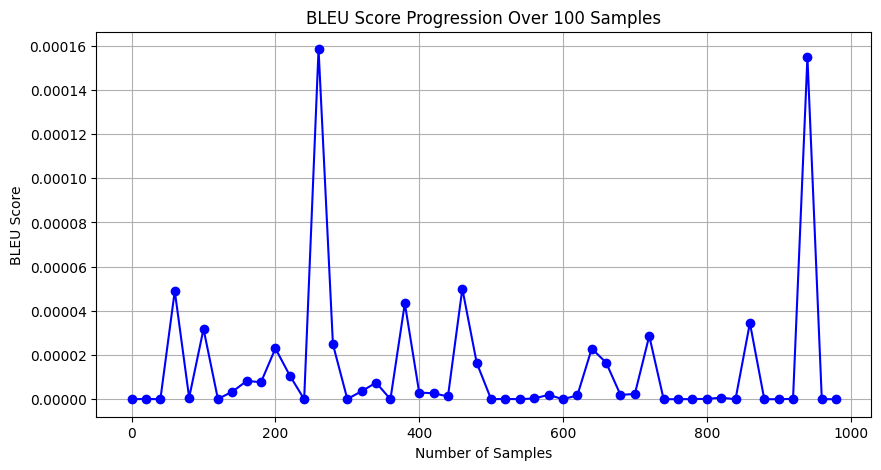

Final BLEU Score: 0.0000


In [ ]:
#Evaluating BART Model on Quora Question-Answer Dataset Using BLEU Score for Generated Answers
from datasets import load_dataset
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
import matplotlib.pyplot as plt

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Load the dataset
dataset = load_dataset("toughdata/quora-question-answer-dataset")

# Initialize the BART model and tokenizer for question answering
model_name = "facebook/bart-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
qa_pipeline = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# Preprocessing functions
def get_wordnet_pos(treebank_tag):
    """Convert treebank tags to wordnet tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def preprocess(text, use_stemming=True):
    tokens = word_tokenize(text.lower())
    if use_stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens if token.isalpha()]
    else:
        lemmatizer = WordNetLemmatizer()
        pos_tags = nltk.pos_tag(tokens)
        tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos) or wordnet.NOUN) for token, pos in pos_tags if token.isalpha()]
    return ' '.join(tokens)

# Select first 100 rows
subset_size = 1000
questions = dataset['train']['question'][:subset_size]
answers = dataset['train']['answer'][:subset_size]

# Preprocess questions and answers
processed_questions = [preprocess(q) for q in questions]
processed_answers = [preprocess(a) for a in answers]

# Generate answers using the BART model
generated_answers = []
for question in tqdm(processed_questions, desc="Generating answers"):
    result = qa_pipeline(question)
    generated_answers.append(result[0]['generated_text'])

# Preprocess generated answers
processed_generated_answers = [preprocess(ans, use_stemming=True) for ans in generated_answers]

# Calculate BLEU scores and plot the progress
def compute_bleu(reference_texts, hypothesis_texts):
    references = [[ref.split()] for ref in reference_texts]
    hypotheses = [hyp.split() for hyp in hypothesis_texts]
    return corpus_bleu(references, hypotheses)

bleu_scores = []
batch_size = 20
for i in tqdm(range(0, len(processed_answers), batch_size), desc="Calculating BLEU scores"):
    batch_references = processed_answers[i:i+batch_size]
    batch_hypotheses = processed_generated_answers[i:i+batch_size]
    bleu_score = compute_bleu(batch_references, batch_hypotheses)
    bleu_scores.append(bleu_score)

# Plot BLEU scores
plt.figure(figsize=(10, 5))
plt.plot(range(0, subset_size, batch_size), bleu_scores, marker='o', linestyle='-', color='b')
plt.title('BLEU Score Progression Over 100 Samples')
plt.xlabel('Number of Samples')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.show()

# Print final BLEU score
final_bleu_score = compute_bleu(processed_answers, processed_generated_answers)
print(f"Final BLEU Score: {final_bleu_score:.4f}")


**Evaluating GPT-2 Model on Quora Question-Answer Dataset Using BLEU Score for Generated Answers**

[nltk_data] Downloading package punkt to /home/akshara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/akshara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/akshara/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Generating answers:   0%|                                                                                                     | 0/100 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id

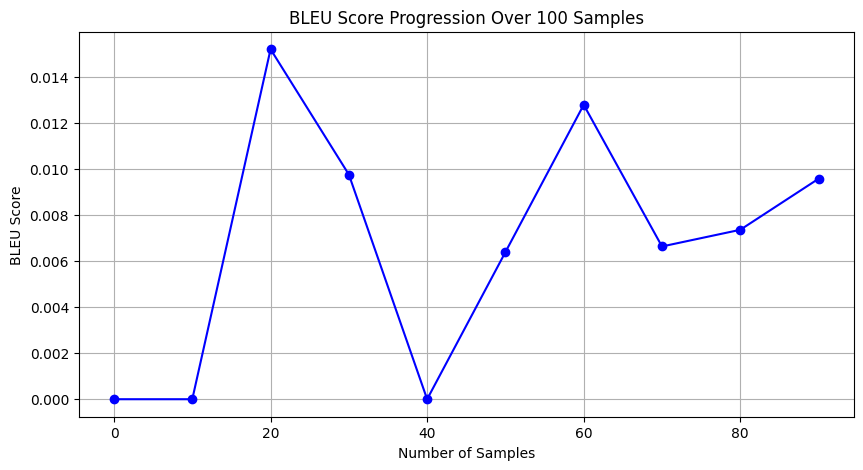

Final BLEU Score: 0.0085


In [ ]:
#Evaluating GPT-2 Model on Quora Question-Answer Dataset Using BLEU Score for Generated Answers"
from datasets import load_dataset
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
import matplotlib.pyplot as plt

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Load the dataset
dataset = load_dataset("toughdata/quora-question-answer-dataset")

# Initialize the GPT-2 model and tokenizer for question answering
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
qa_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Preprocessing functions
def get_wordnet_pos(treebank_tag):
    """Convert treebank tags to wordnet tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def preprocess(text, use_stemming=True):
    tokens = word_tokenize(text.lower())
    if use_stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens if token.isalpha()]
    else:
        lemmatizer = WordNetLemmatizer()
        pos_tags = nltk.pos_tag(tokens)
        tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos) or wordnet.NOUN) for token, pos in pos_tags if token.isalpha()]
    return ' '.join(tokens)

# Select first 100 rows
subset_size = 100
questions = dataset['train']['question'][:subset_size]
answers = dataset['train']['answer'][:subset_size]

# Preprocess questions and answers
processed_questions = [preprocess(q) for q in questions]
processed_answers = [preprocess(a) for a in answers]

# Generate answers using the GPT-2 model
generated_answers = []
for question in tqdm(processed_questions, desc="Generating answers"):
    result = qa_pipeline(question, max_length=500, num_return_sequences=1)
    generated_answers.append(result[0]['generated_text'])

# Preprocess generated answers
processed_generated_answers = [preprocess(ans, use_stemming=True) for ans in generated_answers]

# Calculate BLEU scores and plot the progress
def compute_bleu(reference_texts, hypothesis_texts):
    references = [[ref.split()] for ref in reference_texts]
    hypotheses = [hyp.split() for hyp in hypothesis_texts]
    return corpus_bleu(references, hypotheses)

bleu_scores = []
batch_size = 10
for i in tqdm(range(0, len(processed_answers), batch_size), desc="Calculating BLEU scores"):
    batch_references = processed_answers[i:i+batch_size]
    batch_hypotheses = processed_generated_answers[i:i+batch_size]
    bleu_score = compute_bleu(batch_references, batch_hypotheses)
    bleu_scores.append(bleu_score)

# Plot BLEU scores
plt.figure(figsize=(10, 5))
plt.plot(range(0, subset_size, batch_size), bleu_scores, marker='o', linestyle='-', color='b')
plt.title('BLEU Score Progression Over 100 Samples')
plt.xlabel('Number of Samples')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.show()

# Print final BLEU score
final_bleu_score = compute_bleu(processed_answers, processed_generated_answers)
print(f"Final BLEU Score: {final_bleu_score:.4f}")
